## **Load libs**

In [ ]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras.optimizers import Adam, SGD
from keras.layers import Flatten
from keras.losses import mse
from skimage.metrics import peak_signal_noise_ratio
from sklearn.metrics import mean_squared_error
import tifffile
from Model import *
from skimage.util import random_noise
import pickle

## **Set Parameters**

In [ ]:
loss_function = mse
optimizer = Adam(learning_rate=0.001)
num_iter = 20000
save_every = 20
num_channels = 1
sigma = 25

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## **Load Image and add noise**

In [ ]:
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = np.array(image)
    image = image.astype(np.float32) / 255. if np.max(image) > 1 else image
    image = np.expand_dims(image, axis=-1) if len(image.shape) == 2 else image
    return image

In [ ]:
image = preprocess_image('cameraman.jpg')

In [ ]:
#noisy_image = preprocess_image('pirate_s&p06.jpg')

In [ ]:
noisy_image = image + np.random.normal(0, sigma/255., image.shape)
noisy_image = np.clip(noisy_image, 0, 1)

In [ ]:
peak_signal_noise_ratio(image, noisy_image)

<ipython-input-7-d8181ae8fc0a>:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  peak_signal_noise_ratio(image, noisy_image)


20.545242515575563

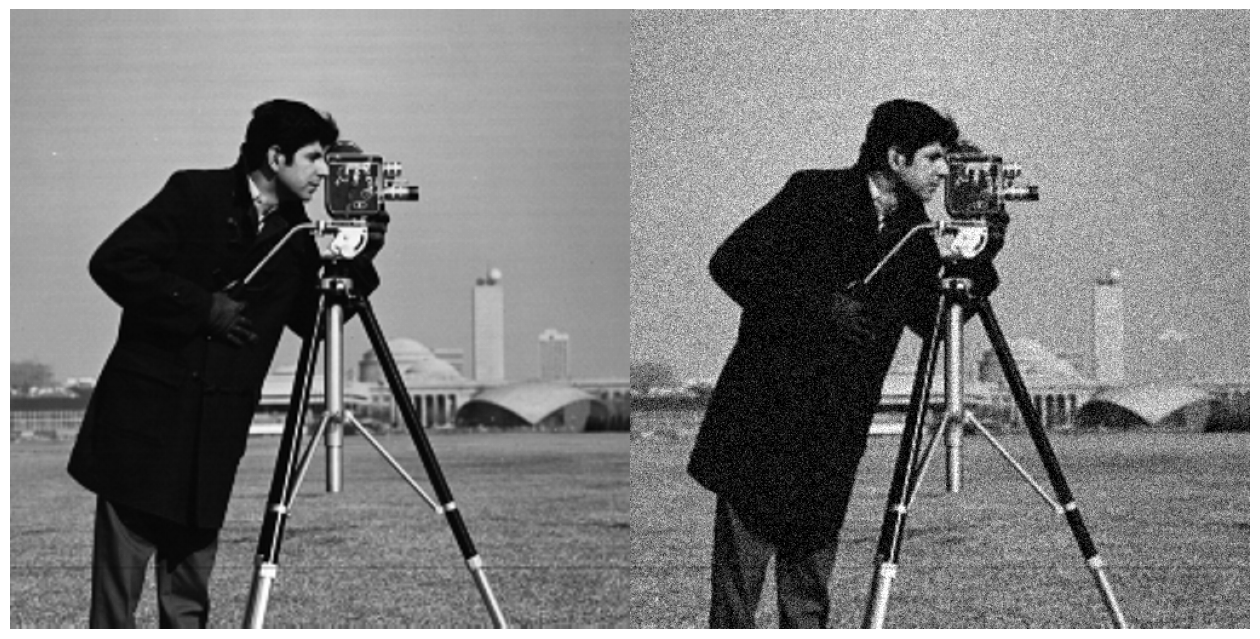

In [ ]:
plot_image = np.concatenate((image, noisy_image), axis=1)

plt.figure(figsize=(16, 25), frameon=False)

if num_channels == 1:
  plt.imshow(plot_image, cmap='gray')
else:
  plt.imshow(plot_image)

plt.axis('off')

plt.show()

## **Create Model**

In [ ]:
model = create_model(image.shape)
model.summary();

Model: "Encoder-Decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 8)          80        ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 8)          32        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 8)          0         ['batch_normaliz

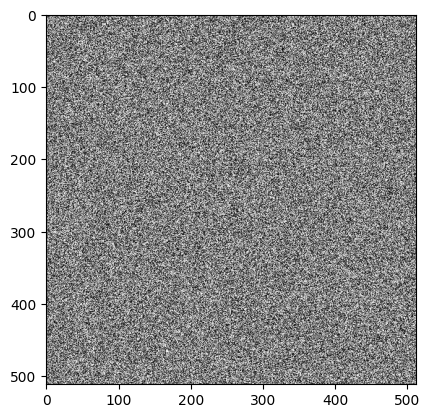

In [ ]:
net_input = (np.random.uniform(0, 1, image.shape)).astype(np.float32) * 1/10.
plt.imshow(net_input, cmap='gray') if num_channels == 1 else plt.imshow(net_input)

In [ ]:
#net_input = (np.random.uniform(0, 1, (512,512,32))).astype(np.float32)

In [ ]:
x = np.expand_dims(net_input, axis=0)
y = noisy_image
pred_list = []
loss_list = []
psnr_list = []
mse_list = []

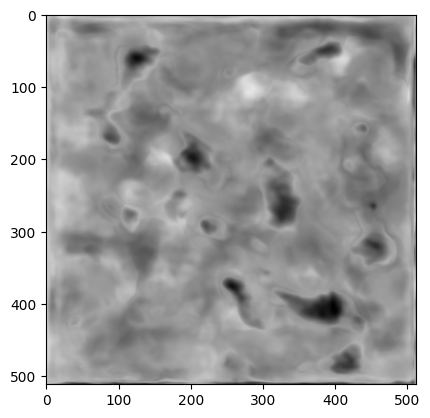

In [ ]:
pred = model(x)
pred = np.reshape(pred, image.shape)
plt.imshow(pred, cmap='gray') if num_channels == 1 else plt.imshow(pred)

## **Start Optimization**

In [ ]:
def step(model, x, y, loss_function, optimizer):
    with tf.GradientTape() as tape:
        pred = model(x)
        pred_f = Flatten()(pred)
        loss = loss_function(y.flatten(), pred_f)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return pred, loss[0].numpy()

In [ ]:
for i in range(num_iter+1):
    pred, loss = step(model, x, y, loss_function, optimizer)
    if i % save_every == 0:
        pred = np.reshape(pred, image.shape)
        psnr = peak_signal_noise_ratio(image, pred)
        mse_ = mean_squared_error(image.flatten(), pred.flatten())
        pred_list.append(pred)
        loss_list.append(loss)
        psnr_list.append(psnr)
        mse_list.append(mse_)
        if i % 500 == 0:
          print('Iteration:', i)
          print('Loss:', np.round(loss, 5))
          print('PSNR:', np.round(psnr, 5))
          print('MSE:', np.round(mse_, 5))
          print('-------------')
        # plt.figure()
        # plt.imshow(pred, cmap='gray') if num_channels == 1 else plt.imshow(pred)

Iteration: 0
Loss: 0.06545
PSNR: 12.20395
MSE: 0.0602
-------------
Iteration: 500
Loss: 0.01152
PSNR: 25.08002
MSE: 0.0031
-------------
Iteration: 1000
Loss: 0.01022
PSNR: 27.26627
MSE: 0.00188
-------------
Iteration: 1500
Loss: 0.00988
PSNR: 27.98796
MSE: 0.00159
-------------
Iteration: 2000
Loss: 0.00929
PSNR: 29.19505
MSE: 0.0012
-------------
Iteration: 2500
Loss: 0.00924
PSNR: 28.77094
MSE: 0.00133
-------------
Iteration: 3000
Loss: 0.00898
PSNR: 29.5952
MSE: 0.0011
-------------
Iteration: 3500
Loss: 0.00893
PSNR: 29.59424
MSE: 0.0011
-------------
Iteration: 4000
Loss: 0.00872
PSNR: 29.5455
MSE: 0.00111
-------------
Iteration: 4500
Loss: 0.00869
PSNR: 29.59096
MSE: 0.0011
-------------
Iteration: 5000
Loss: 0.00879
PSNR: 28.65318
MSE: 0.00136
-------------
Iteration: 5500
Loss: 0.0086
PSNR: 29.56471
MSE: 0.00111
-------------
Iteration: 6000
Loss: 0.0085
PSNR: 28.94011
MSE: 0.00128
-------------
Iteration: 6500
Loss: 0.00843
PSNR: 29.11859
MSE: 0.00123
-------------
Iterat

## **Save Outcome**

In [ ]:
pred_list_short = []
pred_list_short.append(noisy_image)
pred_list_short.append(pred_list[np.argmax(psnr_list)])
pred_list_short.append(image)

In [ ]:
erg_dict = {'pred_list_short': pred_list_short, 'loss_list': loss_list, 'psnr_list': psnr_list, 'mse_list': mse_list}

In [ ]:
with open("erg_cameraman_standard_model.pkl", "wb") as temp:
    pickle.dump(erg_dict, temp)

## **Evaluate Outcome**

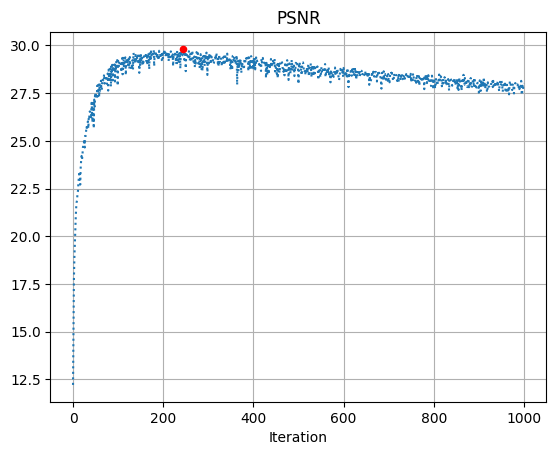

In [ ]:
plt.plot(psnr_list, linestyle=':')
plt.title('PSNR')
plt.xlabel('Iteration')
plt.grid(True)
plt.scatter(np.argmax(psnr_list), max(psnr_list), s=20, color='red', zorder=10)

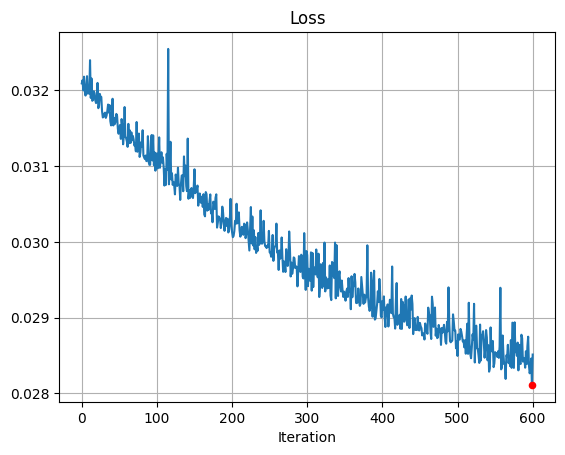

In [ ]:
plt.plot(loss_list[150:], linestyle='-')
plt.title('Loss')
plt.xlabel('Iteration')
plt.grid(True)
plt.scatter(np.argmin(loss_list[150:]), min(loss_list[150:]), s=20, color='red', zorder=10)

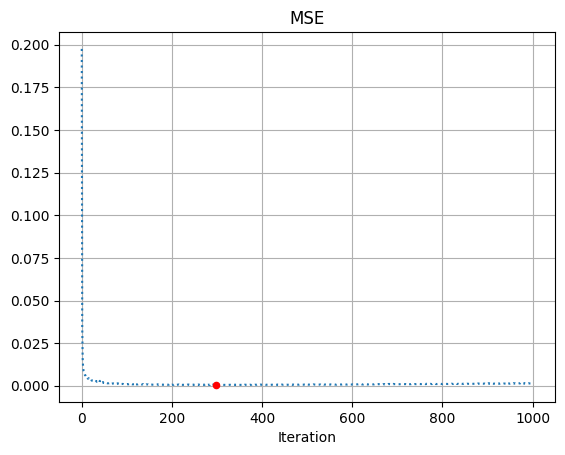

In [ ]:
plt.plot(mse_list, linestyle=':')
plt.title('MSE')
plt.xlabel('Iteration')
plt.grid(True)
plt.scatter(np.argmin(mse_list), min(mse_list), s=20, color='red', zorder=10)

In [ ]:
for pred in pred_list_short:
  plt.figure()
  plt.imshow(pred, cmap='gray') if num_channels == 1 else plt.imshow(pred)

NameError: name 'pred_list_short' is not defined

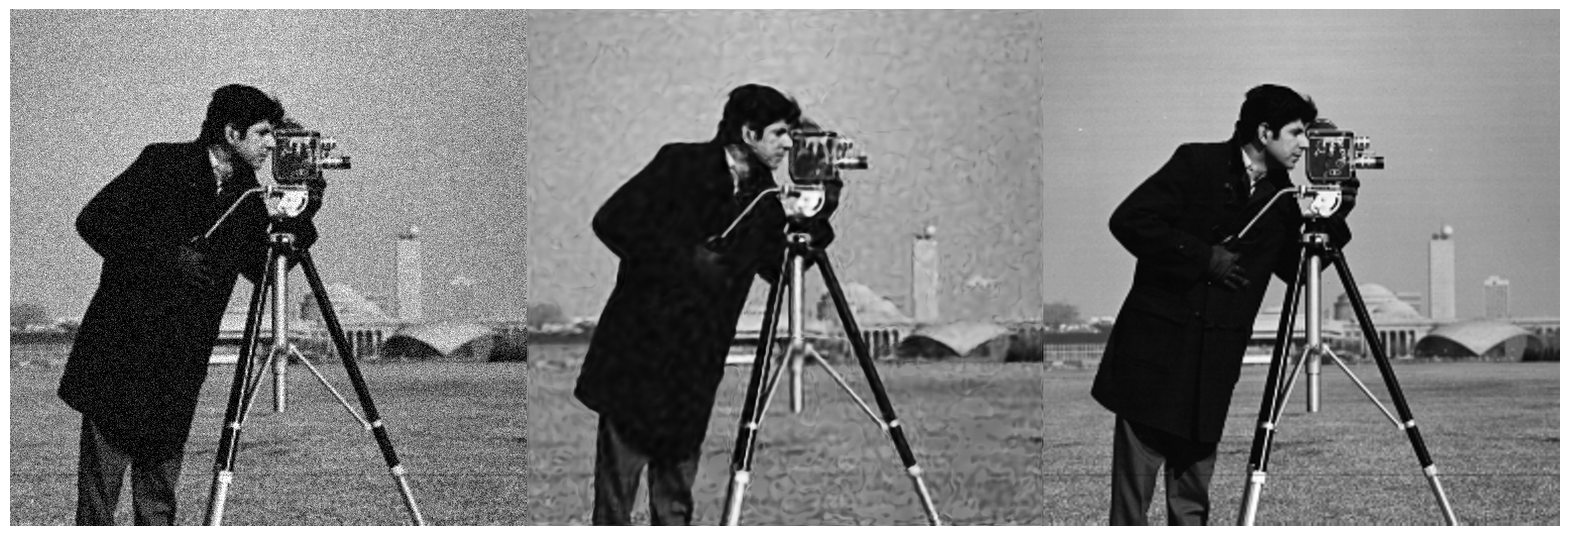

In [ ]:
plot_image = np.concatenate((noisy_image, pred_list_short2[-2], image), axis=1)

plt.figure(figsize=(20, 30), frameon=False)

plt.imshow(plot_image, cmap='gray', interpolation='lanczos')
plt.axis('off')

plt.show()